<a href="https://colab.research.google.com/github/OD1992/Python-programs/blob/main/Hospi_change_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

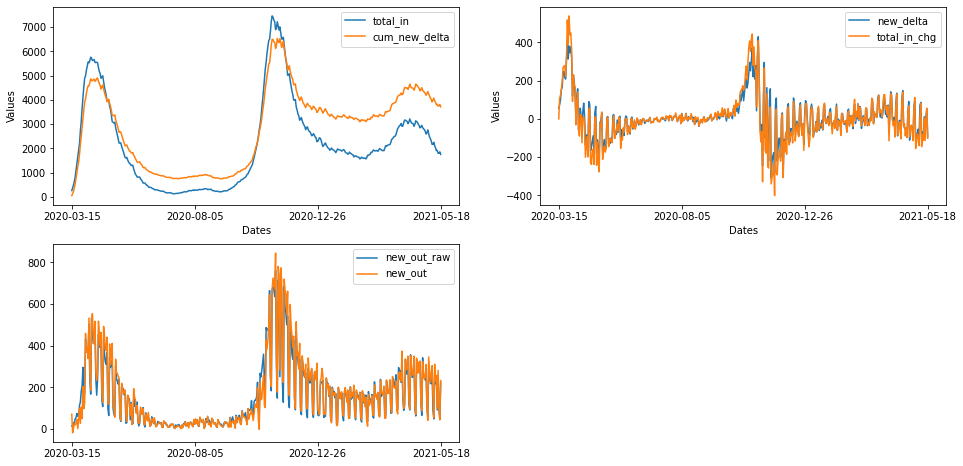

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
#import datetime
#import time

#*******************************************************************************************************
#********* We decide to work with Hospi data in order to show the evolution of beta and identigy the change point
#**************Meeting between Niko, PA and me on 12/12/2022
#Horpitalizations data in Belgium
import copy
from datetime import datetime   # useful for date ranges in plots

sw_dataset = 'BEL'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris, or sw_districts = 'London').  # PATODO fix London and stuff.
# ***********************************************************************************
# Load data Belgium
# *******   
# The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
# This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
# The link can be reached from https://epistat.wiv-isp.be/covid/
# Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf
data_url='/COVID19BE_HOSP_2021-05-16.csv'
data_raw = pd.read_csv(data_url)  # !! changed:21PA
#fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']

if sw_districts == 'each':
    data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1
    
if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts])

    # ***********************************************************************************
    # Process data Belgium
    # *******
    
    if sw_districts == 'sum':
        data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
    elif sw_districts == 'each':
        data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
    else:   
        data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

    data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns
        
    # Extract relevant data and recompute new_out:
    # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
    data_length = np.size(data,0)
    data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd--last columns (recall that Python uses 0-based indexing) and turn it into a numpy array of floats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

    #dates = data['DATE'])
    dates_raw = copy.deepcopy(data['DATE'])
    dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
    Dates = [None] * data_length
    for i in range(0,data_length):
        Dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

    col_total_in = 1
    col_new_in = 5
    col_new_out = 6
    total_in = data_num[:,col_total_in]
    new_in = data_num[:,col_new_in]
    new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
    new_delta = new_in - new_out_raw
    cum_new_delta = np.cumsum(new_delta)
    total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
    # Problem: new_delta and total_in_chg are different, though they are sometimes close. 
    # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
    # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
    new_out = new_in - total_in_chg   # fixed new_out
    data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

    # Show Belgian data in figures:
    nb_xticks = 4
    dates_ticks = [None] * nb_xticks
    dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
    for i in range(0,nb_xticks):
        dates_ticks[i] = Dates[dates_ticks_ind[i]]

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.plot(Dates, total_in)
    plt.plot(Dates,cum_new_delta)
    plt.xticks(dates_ticks)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("total_in","cum_new_delta"))
    #plt.ylim([0,1000])

    plt.subplot(2,2,2)
    plt.plot(Dates,new_delta)
    plt.plot(Dates,total_in_chg)
    plt.xticks(dates_ticks)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("new_delta","total_in_chg"))

    plt.subplot(2,2,3)
    plt.plot(Dates,new_out_raw)
    plt.plot(Dates,new_out)
    plt.xticks(dates_ticks)
    plt.legend(("new_out_raw","new_out"))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


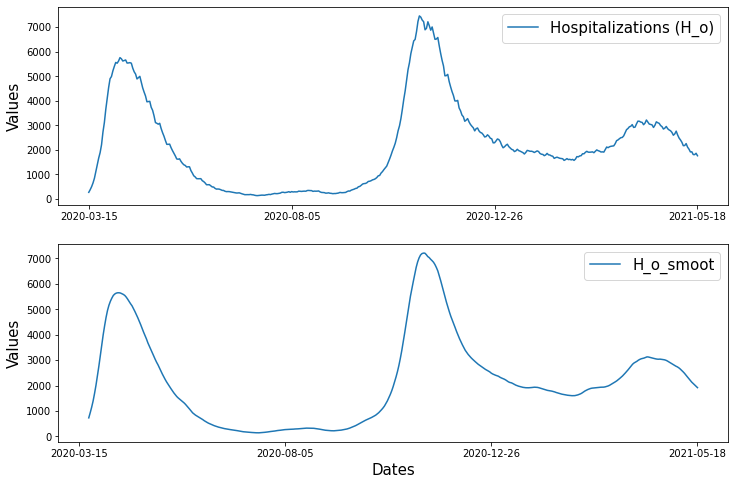

In [3]:
#Calculate and show the H_smooth with Moving Average method
N = 7  # The window length of moving average will be 2N+1.
H_smooth_MA = total_in * np.nan  # MA: moving average
for t in np.arange(0, len(total_in)):
    H_smooth_MA[t] = np.mean(total_in[t-N:t])

nb_xticks = 4
dates_ticks = [None] * nb_xticks
dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
for i in range(0,nb_xticks):
    dates_ticks[i] = Dates[dates_ticks_ind[i]]

plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(Dates, total_in, label="Hospitalizations (H_o)")
plt.xticks(dates_ticks)
#plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(fontsize=15)
plt.subplot(2,1,2)
plt.plot(Dates, H_smooth_MA, label="H_o_smoot")
plt.xticks(dates_ticks)
plt.xlabel("Dates", fontsize=15)
plt.ylabel("Values", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Optimization terminated successfully.
         Current function value: 2222.949974
         Iterations: 50
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: 1819.317066
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 1041.977089
         Iterations: 52
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 958.957489
         Iterations: 54
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 2086.142925
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 3946.827130
         Iterations: 69
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 5437.235316
         Iterations: 62
         Function evaluations: 118
Optimizat

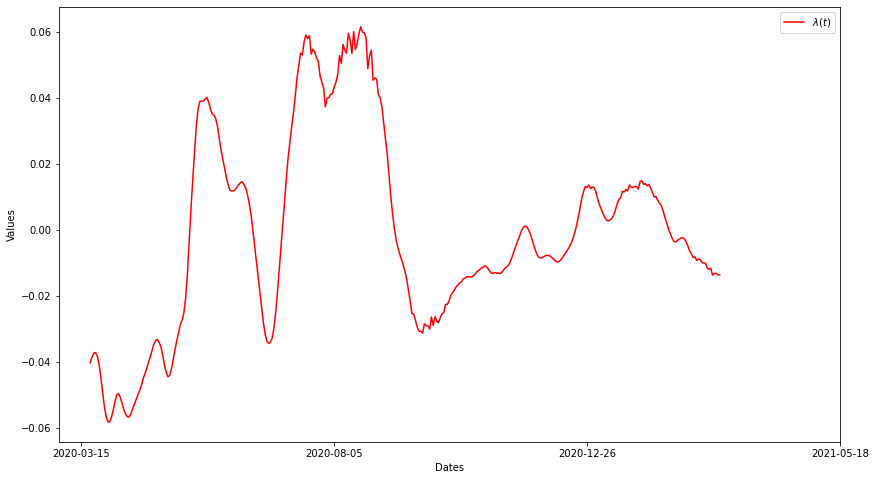

In [38]:
H_smooth_MA = H_smooth_MA[7:]
from scipy import optimize

# let's define the function form
def simu(H_init, beta_effective, tspan):
    simu_t_start = tspan[0]
    simu_t_end = tspan[1]
    H_smooth = np.full(simu_t_end, np.nan)  # set storage
    #Note: beta_effective = beta-gamma
    for t in np.arange(simu_t_start,simu_t_end):
       H_smooth[t] = H_init* np.exp(beta_effective*t)
    return H_smooth

def phi_exp(x, tspan_train, data_train):   # x := [H_init,beta_effective]
    H_init = x[0]
    beta_effective = x[1]
    H_smooth= simu(H_init,  beta_effective, tspan_train)  
    cost = (np.linalg.norm(H_smooth[train_t_start:train_t_end]-data_train[train_t_start:train_t_end]))**2
    return cost


d=5
beta_effective_opt_exp = H_smooth_MA*np.nan
H_init_opt_exp = H_smooth_MA*np.nan
for t in np.arange(d, len(H_smooth_MA)-d):
    train_t_start=t-d
    train_t_end = t+d
    tspan_train = [train_t_start,train_t_end]
    data_train = H_smooth_MA
    H_init = data_train[train_t_start]
    beta_effective_guess = np.log(data_train[train_t_end]/data_train[train_t_start])/(train_t_end)
    
    fun_exp = lambda x:phi_exp(x,tspan_train,data_train)
    x_guess_exp = [H_init, beta_effective_guess]
    x_opt_exp = optimize.fmin(fun_exp,x_guess_exp)  # call the optimization solver
    H_init_opt_exp[t] = x_opt_exp[0]
    beta_effective_opt_exp[t] = x_opt_exp[1]

print(H_init_opt_exp)
plt.figure(figsize=(14,8))
plt.plot(Dates[d:len(H_smooth_MA)-d], beta_effective_opt_exp[d:len(H_smooth_MA)-d], color='red')
plt.xticks(dates_ticks)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend(['$\lambda (t)$'])
plt.show()


Optimization terminated successfully.
         Current function value: 1609.234068
         Iterations: 49
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 1052.045719
         Iterations: 55
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: 1078.853631
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 971.180289
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 406.066631
         Iterations: 67
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 518.055881
         Iterations: 62
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 975.496638
         Iterations: 57
         Function evaluations: 111
Optimizatio

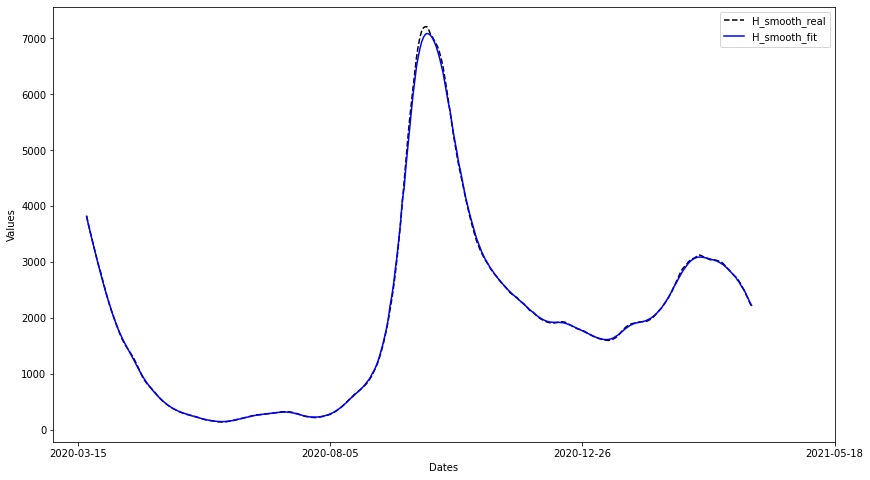

In [33]:

H = H_smooth_MA*np.nan
d=5
for t in np.arange(d, len(H_smooth_MA)-d):
    train_t_start=t-d
    train_t_end = t+d
    tspan_train = [train_t_start,train_t_end]
    data_train = H_smooth_MA
    H_init = data_train[train_t_start]
    beta_effective_guess = np.log(data_train[train_t_end]/data_train[train_t_start])/(train_t_end)
    fun_exp = lambda x:phi_exp(x,tspan_train,data_train)
    x_guess_exp = [H_init, beta_effective_guess]
    x_opt_exp = optimize.fmin(fun_exp,x_guess_exp)  # call the optimization solver
    H_init_opt_exp = x_opt_exp[0]
    beta_effective_opt_exp = x_opt_exp[1]
    H[t] = H_init_opt_exp*np.exp(beta_effective_opt_exp*t)

print(pd.DataFrame({"real":H_smooth_MA[5:20], "fit":H[5:20]})) 

plt.figure(figsize=(14,8))
plt.plot(Dates[d:len(H_smooth_MA)-d], H_smooth_MA[d:len(H_smooth_MA)-d],'--',  color='black') 
plt.plot(Dates[d:len(H_smooth_MA)-d], H[d:len(H_smooth_MA)-d],'-', color='blue')  
plt.xticks(dates_ticks)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend(['H_smooth_real', 'H_smooth_fit'])
plt.show()

P-value:  0.05649523247913013


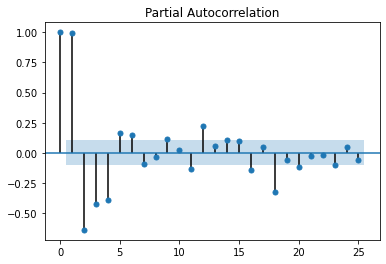

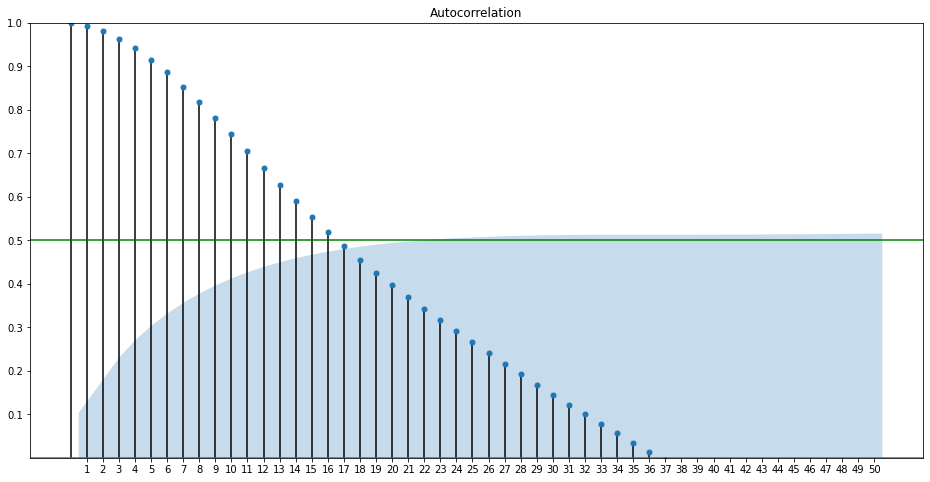

In [88]:
# Load AutoReg class from statsmodels.tsa.ar_model module
from statsmodels.tsa.ar_model import AutoReg
data = beta_effective_opt_exp[d:len(H_smooth_MA)-d]

# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
from statsmodels.tsa.stattools import adfuller
# Run the test
df_stationarityTest = adfuller(data, autolag='AIC')
# Check the value of p-value
print("P-value: ", df_stationarityTest[1])
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf = plot_pacf(data, lags=25)

#As mentioned above, values above 0.5 or below -0.5 are considered to have a high correlation, so when looking at the plot we can use these values as thresholds to decide to either include or disregard a specific lag.
fig, ax = plt.subplots(figsize=(16,8))
plot_acf(data, lags=50, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(1, 51, 1))
plt.axhline(y=0.5, color="green")
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


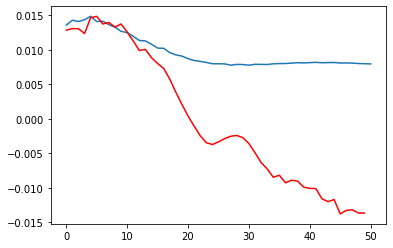

In [89]:
train_data = data[:len(data)-50]
train_data=train_data #+ 1.5e-4*np.random.randn(len(train_data))
test_data = data[len(data)-50:]
ar_model = AutoReg(train_data, lags=16).fit()
#print(ar_model.summary())

pred = ar_model.predict(start=len(train_data), end=(len(data)), dynamic=False) 
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test_data, color='red')

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  357
Model:                     AutoReg(2)   Log Likelihood                1696.100
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Wed, 14 Dec 2022   AIC                            -12.371
Time:                        15:54:06   BIC                            -12.327
Sample:                             2   HQIC                           -12.353
                                  357                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.618e-05      0.000      0.150      0.881      -0.000       0.000
y.L1           1.6413      0.040     40.725      0.000       1.562       1.720
y.L2          -0.6487      0.040    -16.131      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


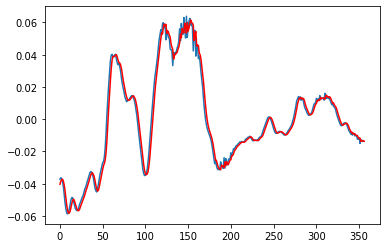

In [43]:
# Instantiate and fit the AR model with training data
ar_model = AutoReg(data, lags=2).fit()
# Print Summary
print(ar_model.summary())

# Make the predictions
pred = ar_model.predict(start=0, end=len(data), dynamic=False)
# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(data, color='red')